In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_svmlight_file
import pdb
from sklearn import svm, linear_model
from sklearn.ensemble import RandomForestClassifier
import random

In [2]:
#Load data from given files
from itertools import izip_longest
import csv
with open('dexter_train.labels', 'rb') as csv1,open('dexter_train.data', 'rb') as csv2,open('concat.txt', 'w') as out:
    spam1 = csv.reader(csv1)
    spam2 = csv.reader(csv2)
    last_column=list(izip_longest(*spam2))[-1]
    for i,j in  izip_longest(spam1,last_column):
        out.write(','.join([t.strip(';') for t in i])+' '+j+'\n')
        
from itertools import izip_longest
import csv
with open('dexter_valid.labels', 'rb') as csv1,open('dexter_valid.data', 'rb') as csv2,open('valid.txt', 'w') as out:
    spam1 = csv.reader(csv1)
    spam2 = csv.reader(csv2)
    last_column=list(izip_longest(*spam2))[-1]
    for i,j in  izip_longest(spam1,last_column):
        out.write(','.join([t.strip(';') for t in i])+' '+j+'\n')

In [3]:
TrainData = load_svmlight_file("concat.txt")#created in the cell above
valid=load_svmlight_file('valid.txt')#created in the cell above

In [4]:
X=TrainData[0] #training data
Ytrain=TrainData[1] #training label
Xv=valid[0] # validating data
Yvalid=valid[1] # validating labels
N,d=X.shape

In [5]:
Xtrain=X.multiply(1/np.sqrt(X.multiply(X).sum(1))) #normalize each row
Xvalid=Xv.multiply(1/np.sqrt(Xv.multiply(Xv).sum(1))) #normalize each row
print(Xtrain.shape, Xvalid.shape)
print(np.linalg.norm(Xtrain[100,:]))
print(np.linalg.norm(Xvalid[100,:]))

((300, 19999), (300, 19999))
1.0
1.0


In [25]:
train_index=random.sample(range(Xtrain.shape[0]), 270 ) # 90% for training, 20% for cross-validation
cv_index=list(set(range(Xtrain.shape[0]))-set(train_index)) #cross-validation set
Xtr=Xtrain
Ytr=Ytrain
Xcv=Xtrain[cv_index,:]
Ycv=Ytrain[cv_index]
pMask=(Yvalid==1)
nMask=(Yvalid==-1)
positiveMask=Ytr==1  # indices of positive points
negativeMask=Ytr==-1 # indices of negative points
numPos=np.sum(positiveMask) # total number of positive points
numNeg=np.sum(negativeMask) # total number of negative points
Xposmean=Xtr[positiveMask,:].mean(0) # take the mean of each column of positive data
Xnegmean=Xtr[negativeMask,:].mean(0) # take the mean of each column of negative data
Xmean=Xtr.mean(0) # mean of features accooss all data points
print(Xtr.shape, Xposmean.shape, Xnegmean.shape, Xmean.shape)

((300, 19999), (1, 19999), (1, 19999), (1, 19999))


In [9]:
def BalancedErrorRate(posMask, negMask, Predict):
    Psvm=Predict[posMask]+Yvalid[posMask] #if zero, then worng prediction on positive class
    Nsvm=Predict[negMask]+Yvalid[negMask] #if zero, then worng prediction on negative class
    errorPsvm=np.sum(Psvm==0) #total number of wrong predicted positive instances
    errorNsvm=np.sum(Nsvm==0) #total number of wrong predicted negative instances
    numPos=np.sum(posMask) #total number of true positive instances
    numNeg=np.sum(negMask) #total number of true negative instances
#     print('number of wrong predicted positive instances',errorPsvm, 'number of wrong predicted negative instances',errorNsvm)
#     print('number of true negative instances',numPos, 'number of true negative instances', numNeg)
    bef= 1.0/2*(errorPsvm*1.0/numPos+errorNsvm*1.0/numNeg)*100
#     print('BEF', bef)
    return bef

In [12]:
# Use SVM
clf = svm.SVC()
clf.fit(Xtr, Ytr) 
PredictSVM=clf.predict(Xvalid)
print('regular error',np.sum(PredictSVM!=Yvalid)/(1.*len(Yvalid))*100)
# Balanced Error Rate from "Feature Extraction" by I. Guyon et al, Chapter 12
# BER=1/2 *(#positive instances predicted worng/positive instances +
#           #negative instances predicted worng/negative instances )

BEF=BalancedErrorRate(pMask, nMask, PredictSVM)
print('BEF', BEF)

('regular error', 39.666666666666664)
('BEF', 39.666666666666664)


## Compute F-score for selecting features

In [26]:
numer=(np.square(Xposmean-Xmean)+np.square(Xnegmean-Xmean)) # numerator for F-score
denomin=np.sum(np.square(Xtrain[positiveMask,:]-Xposmean), axis=0)*1.0/(numPos-1)+ \
np.sum(np.square(Xtrain[negativeMask,:]-Xnegmean), axis=0)*1.0/(numNeg-1) # denominator for F-score
print(numer.shape, denomin.shape)

((1, 19999), (1, 19999))


In [27]:
FScore=np.zeros(numer.shape[1])  # initialize
ind=np.zeros(numer.shape[1]) #keeps indixes of features that have nonzero F-score
k=0 #keeps number of features that have nonzero F-score
for i in range(numer.shape[1]):
    if denomin[0,i]!=0: # otherwise it's =0
        FScore[k]=numer[0,i]/denomin[0,i] # compute F-score
        ind[k]=i # index of nonzero F-score
        k+=1 # increase the number of featurs having nonzero F-score 
print('k',k)   
index=ind[0:k].astype(int) # only first k values are indices needed

('k', 7751)


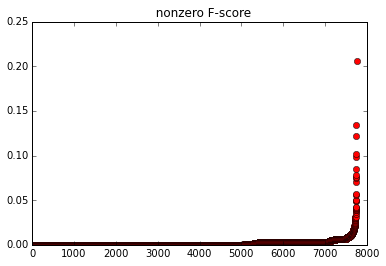

In [28]:
plt.plot(np.sort(FScore[index]),'ro')
plt.title('  nonzero F-score ')

In [22]:
thresh=0.005
maskF=FScore>thresh # keep features whose F-score is grater than threshhold

I=maskF
# print len(I)

In [32]:
# Predict_Fscore=None
# pMask=None
# nMask=None
# Pfscore=None
# Nfscore=None
# print(pMask)
clf = svm.SVC()
clf.fit(Xtr[:,I], Ytr) 
Predict_Fscore=clf.predict(Xcv[:,I])
pvMask=(Ycv==1)
nvMask=(Ycv==-1)

Pvfscore=Predict_Fscore[pvMask]+Ycv[pvMask]
Nvfscore=Predict_Fscore[nvMask]+Ycv[nvMask]
errorPvfscore=np.sum(Pvfscore==0)
errorNvfscore=np.sum(Nvfscore==0)
numPosv=np.sum(pvMask)
numNegv=np.sum(nvMask)
print(errorPvfscore, errorNvfscore)
print(numPosv, numNegv)
BEF=1.0/2*(errorPvfscore*1.0/numPosv+errorNvfscore*1.0/numNegv)*100
print('BEF', BEF)

(0, 14)
(12, 18)
('BEF', 38.888888888888893)


In [34]:
Xtr[:,I].shape

(270, 543)